<a href="https://colab.research.google.com/github/klaadhithya/Image-Denoising-using-Autoencoders/blob/main/NoiseRemoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
SEED = 3
import os
import random as rn
import numpy as np

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.__version__
tf.random.set_seed(SEED)
rn.seed(SEED)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
import tensorflow.keras.layers as layers
from tensorflow.keras import backend as K
import tensorflow.keras.utils
from tensorflow.keras import utils as np_utils
from PIL import Image as im
import cv2

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    return trainX, testX

In [ ]:
trainX, testX= load_dataset()
print(trainX.shape)
print(testX.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
#trainX_final=[]
#for i in range(trainX.shape[0]):
#  trainX_final.append(cv2.resize(trainX[i], dsize=(200, 200), interpolation=cv2.INTER_CUBIC))
testX_final=[]
for i in range(testX.shape[0]):
  testX_final.append(cv2.resize(testX[i], dsize=(200, 200), interpolation=cv2.INTER_CUBIC))

In [ ]:
#testX_final = np.reshape(testX_final, (len(testX_final),200,200,1))

In [ ]:
#trainX=np.array(trainX_final)
#print(trainX.shape)
testX=np.array(testX_final)
print(testX.shape)

(10000, 200, 200)


In [ ]:
def getmask():
  mask=np.zeros((200,1))
  for i in range(50):
    mask=np.append(mask,np.reshape( np.random.uniform(size=200,low=10,high=12),(200,1)),axis=1)
    mask=np.append(mask,np.reshape( np.random.uniform(size=200,low=12,high=14),(200,1)),axis=1)
    mask=np.append(mask,np.reshape( np.random.uniform(size=200,low=1,high=3),(200,1)),axis=1)
    mask=np.append(mask,np.reshape( np.random.uniform(size=200,low=3,high=5),(200,1)),axis=1)
  mask=mask[:,1:]
  #adding gaussian noise to mask
  mask=np.add(mask,0.5*np.random.normal(0,1,(200,200)))
  #mask=np.clip(mask, 0.0, 1.0)
  #mask=np.reshape(mask,(200,200,1))
  return mask

Rough

In [ ]:
mask1=getmask()

In [ ]:
mask1.shape

(200, 200)

In [ ]:
img=testX[0]

In [ ]:
img1=np.add(img,mask1)
#img1=np.clip(img1, 0.0, 1.0)

In [ ]:
img1.shape

(200, 200)

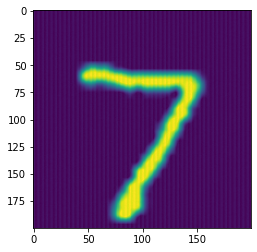

In [ ]:
plt.imshow(img1)


Code:

In [ ]:
testX_noisy=[]

In [ ]:
for i in range(10):
  mask2=getmask()
  for j in range(1000):
    testX_noisy.append(np.add(testX[i*1000+j],mask2))

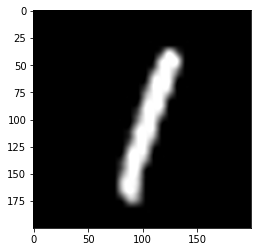

In [ ]:
plt.imshow(testX[5])
plt.gray()

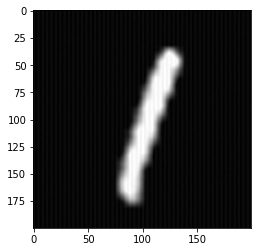

In [ ]:
plt.imshow(testX_noisy[5])

Splitting testX(10,000 images) as train and test again

In [ ]:
testX = testX.astype("float32") / 255.0

In [ ]:
testX_noisy=np.array(testX_noisy)
testX_noisy=testX_noisy.astype("float32")/255.0

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(testX_noisy, testX, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 200, 200)
(2000, 200, 200)
(8000, 200, 200)
(2000, 200, 200)


Autoencoder

In [ ]:
input = layers.Input(shape=(200, 200, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0     

In [ ]:
autoencoder.fit(
    x=X_train,
    y=y_train,
    epochs=5,
    batch_size=64,
    shuffle=True,
    validation_data=(X_test, y_test),
)

Epoch 1/5
125/125 [==============================] - 32s 170ms/step - loss: 0.1786 - val_loss: 0.0782
Epoch 2/5
125/125 [==============================] - 21s 169ms/step - loss: 0.0766 - val_loss: 0.0762
Epoch 3/5
125/125 [==============================] - 21s 170ms/step - loss: 0.0754 - val_loss: 0.0757
Epoch 4/5
125/125 [==============================] - 21s 172ms/step - loss: 0.0751 - val_loss: 0.0753
Epoch 5/5
125/125 [==============================] - 22s 173ms/step - loss: 0.0748 - val_loss: 0.0751


In [ ]:
predictions = autoencoder.predict(X_test)
predictions=np.reshape(predictions,(2000,200,200))
predictions[0].shape

(200, 200)

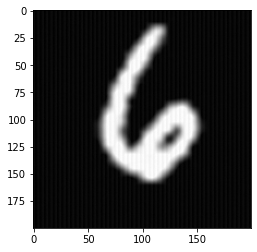

In [ ]:
#Noise Image: input
plt.imshow(X_test[0])

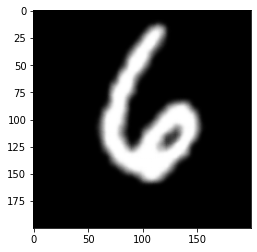

In [ ]:
plt.imshow(predictions[0])

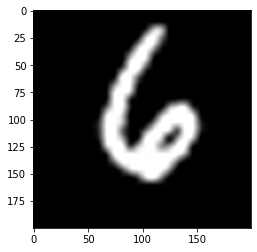

In [ ]:
plt.imshow(y_test[0])